In [1]:
import pandas as pd
import os
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
import matplotlib.pyplot as plt
import pydeseq2 as deseq2
from pydeseq2.dds import DeseqDataSet
from pydeseq2.preprocessing import deseq2_norm

from analysis.custom_functions import *

save_format = "svg"

# Load data

## Bulk gastruloid
For this analysis, we will only retain the samples from the 72h and the initial condition at 48h, immediately before Chiron treatment.

In [2]:
#Counts
df_gastruloid = pd.read_csv("data/gastruloid_bulk.csv",index_col=0).T
df_gastruloid = df_gastruloid.loc[:,~df_gastruloid.columns.duplicated()].copy() #Remove potentially duplicated genes names (very few and irrelevant genes are duplicated)

In [3]:
#Metadata
df_gastruloid_metadata = pd.read_csv("data/gastruloid_bulk_metadata.csv",index_col=0)

In [4]:
# Marker genes
marker_genes = pd.read_csv("marker_genes.csv",header=None).values[:,0]

# Preprocessing and QC

**DATASET EXPLORATION**

In [5]:
print(f"Samples in dataset: {df_gastruloid.shape[0]}")
print(f"Genes in dataset: {df_gastruloid.shape[1]}")

Samples in dataset: 30
Genes in dataset: 36448


**LIBRARY SIZES AND LOGCOUNTS**

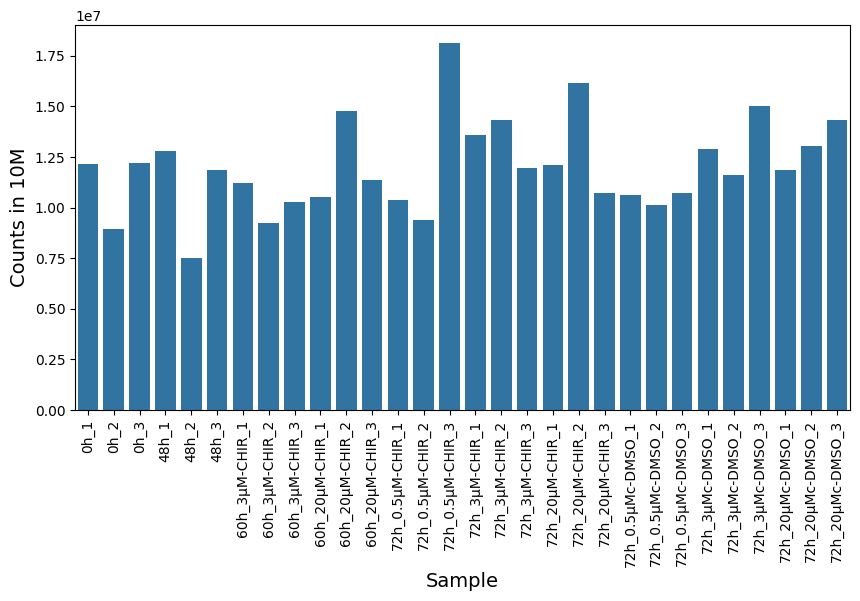

In [6]:
fig,ax=plt.subplots(1,1,figsize=(10,5))
sns.barplot(df_gastruloid, x=df_gastruloid.index, y=df_gastruloid.sum(axis=1),ax=ax)

plt.xticks(rotation=90)
plt.xlabel('Sample', size=14)
plt.ylabel('Counts in 10M', size=14)

# create result folder
plt.savefig(f"results/bulk_library_sizes.{save_format}")

In [7]:
log_df=np.log1p(df_gastruloid)

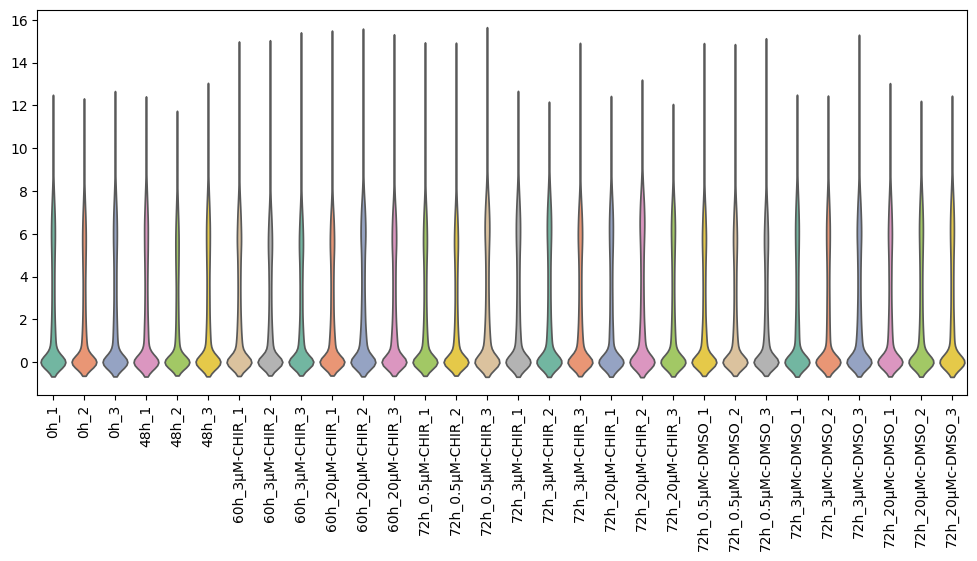

In [8]:
fig,ax=plt.subplots(1,1,figsize=(12,5))

sns.violinplot(log_df.T, palette='Set2',inner=None,ax=ax)
plt.xticks(rotation=90)

plt.savefig(f"results/bulk_logcounts_distribution.{save_format}")

# Analysis

In [9]:
os.makedirs(f"results/analysis/", exist_ok=True)

**GET NORMALIZED COUNTS**

Size factor normalization by median of ratios method

In [10]:
# run deseq2_norm fucntion
dds_norm=deseq2_norm(df_gastruloid)

dds_norm[0].to_csv(f"data/normalized_counts.csv")

## Construct DESeq2 object

In [11]:
dds = DeseqDataSet(
    counts=df_gastruloid.values,
    metadata=df_gastruloid_metadata,
    design_factors="Condition",
    refit_cooks=True
)

/home/gatocor/.local/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/gatocor/.local/lib/python3.11/site-packages/pydeseq2/dds.py:257: UserWarning: Some factor levels in the design contain underscores ('_').
                    They will be converted to hyphens ('-').
  self.obsm["design_matrix"] = build_design_matrix(


## Variance Stabilizing Transformation (VST)

We scale the data normalizing the sum of total counts and producing and scaling to log1p.

In [12]:
# run vst algorithm
# transformed counts are stored in .layers
dds.vst()

Fitting size factors...
... done in 0.07 seconds.

Fitting dispersions...
... done in 3.23 seconds.

Fitting dispersion trend curve...
... done in 0.58 seconds.



In [13]:
# create df with transformed counts
df1= pd.DataFrame(data=dds.layers['vst_counts'],    
             index=dds.obs.index,    
             columns=df_gastruloid.columns.values)

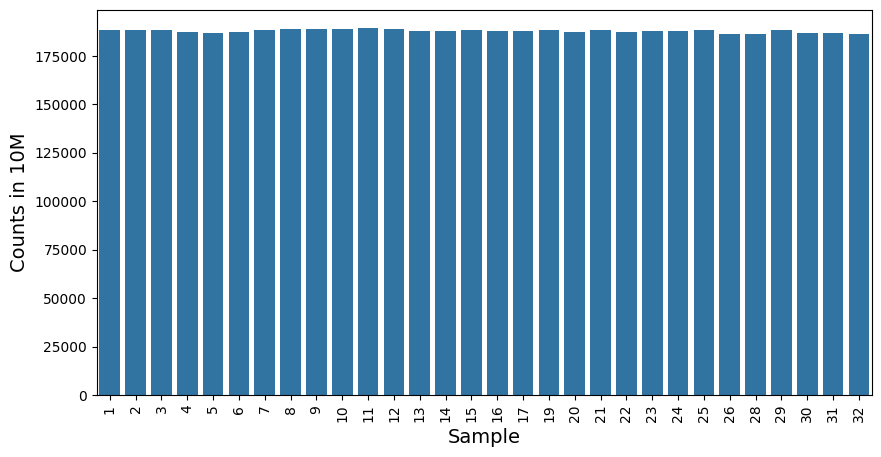

In [14]:
fig,ax=plt.subplots(1,1,figsize=(10,5))
sns.barplot(df1, x=df1.index, y=df1.sum(axis=1),ax=ax)

plt.xticks(rotation=90)
plt.xlabel('Sample', size=14)
plt.ylabel('Counts in 10M', size=14)

# create result folder
plt.savefig(f"results/bulk_library_sizes.{save_format}")

## Feature selection

We select the most varying genes of both datasets and find the common number between both datasets. We use a simple variance threshold to choose the most varying genes.

Free parameters: **threshold**

In [15]:
fs = VarianceThreshold(threshold=1)
fs.fit(df1.values)
l1 = fs.get_feature_names_out()
l = [int(i[1:]) for i in l1]

len(l)

598

## PCA

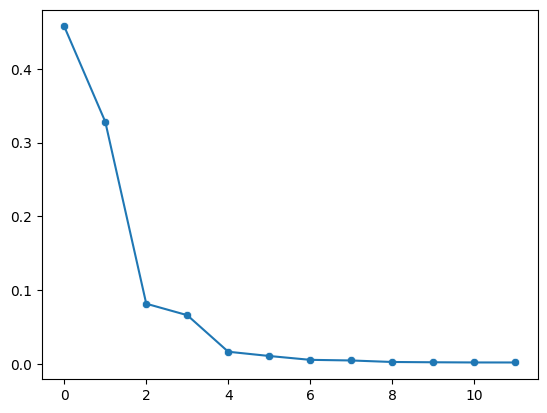

In [16]:
df1_fs = pd.DataFrame(fs.transform(df1.values),index=df1.index,columns=df1.columns.values[l])
pca = PCA(n_components=12)
pca.fit(df1_fs.values)

sns.lineplot(x=np.arange(0,pca.n_components),y=pca.explained_variance_ratio_)
sns.scatterplot(x=np.arange(0,pca.n_components),y=pca.explained_variance_ratio_)

plt.savefig(f"results/bulk_analysis_pca_explained_variance.{save_format}",bbox_inches="tight",transparent=True)

In [17]:
names = df1.columns.values[[int(i[1:]) for i in fs.get_feature_names_out()]]
df1_fs = pd.DataFrame(fs.transform(df1.values),index=df1.index,columns=names)
pca = PCA(n_components=min(4,df1.shape[0]-1))
pca.fit(fs.transform(df1.values));

In [18]:
x = pca.transform(fs.transform(df1.values))

dds.obs['PC1']=x[:,0]
dds.obs['PC2']=x[:,1]

### Representation

Show the PCA components and the Pijuan-Sala projection. The PCA captures time evolution.

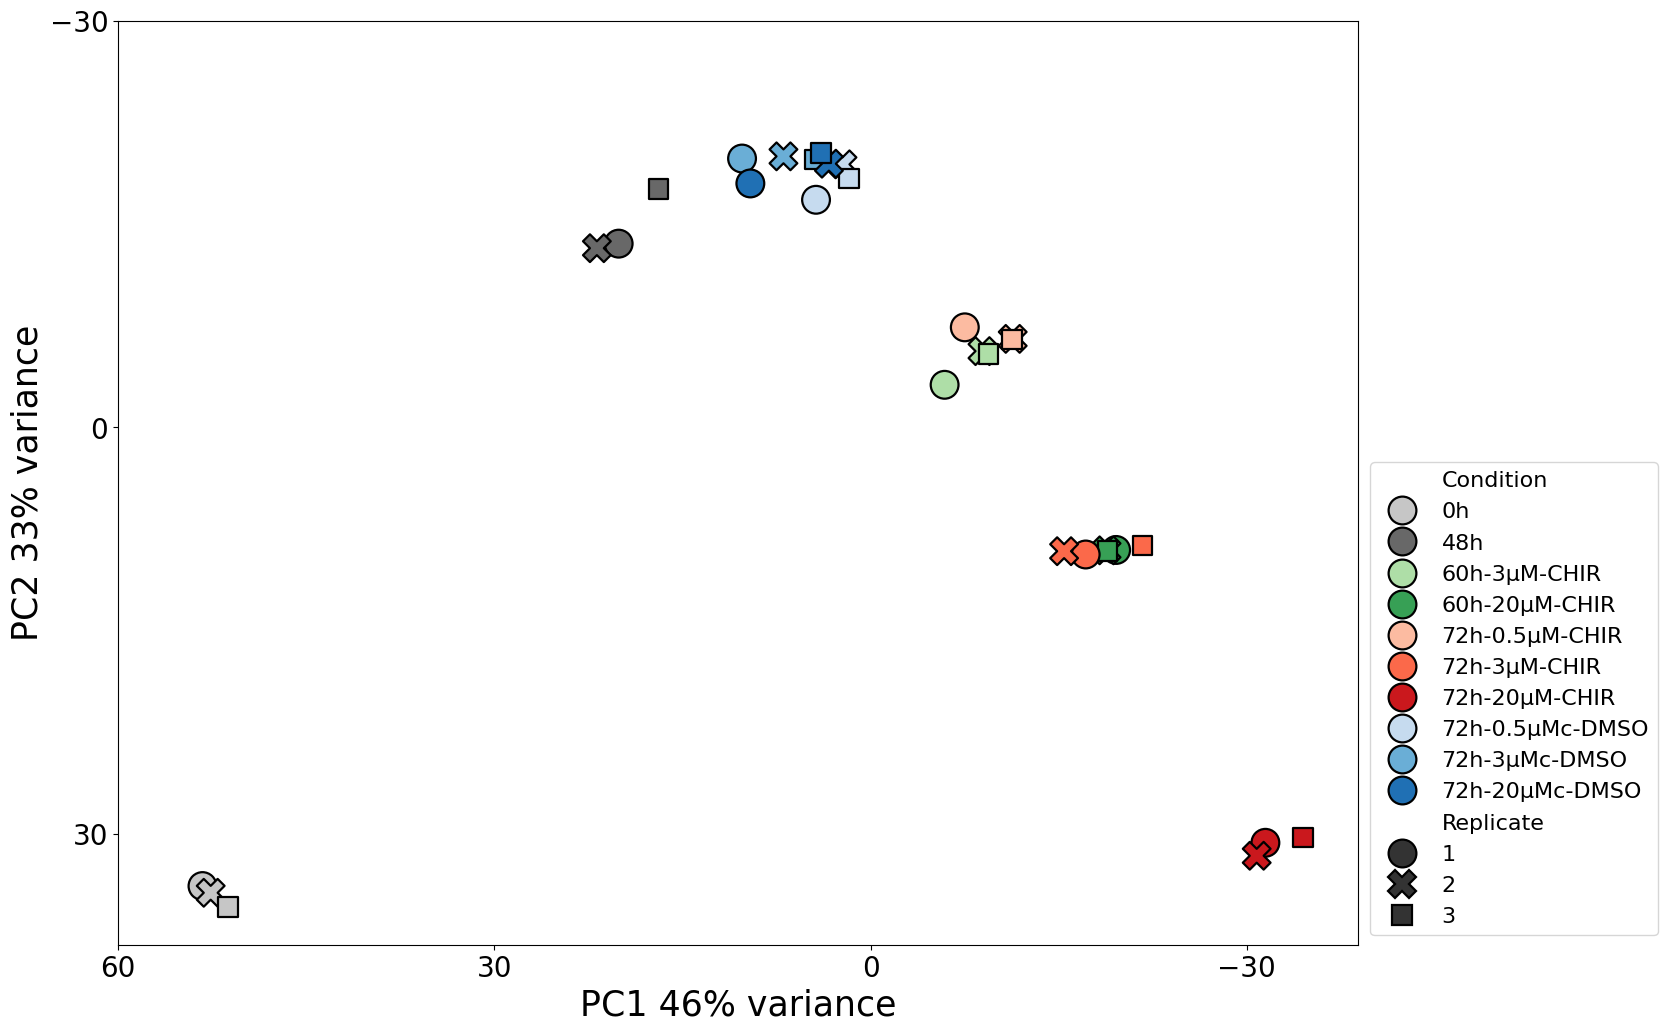

In [30]:
fig,ax=plt.subplots(1,1,figsize=(16,12))
sns.scatterplot(dds.obs[['C_' in i or 'T_' in i for i in dds.obs['ID'].values]],
                       x='PC1', y='PC2', s=400, edgecolor='black',
                       style='Replicate',hue='Condition', ax=ax, palette='Greys')
sns.scatterplot(dds.obs[['60h' in i  for i in dds.obs['ID'].values]],
                        x='PC1', y='PC2', s=400, edgecolor='black',
                        style='Replicate', hue='Condition', ax=ax, palette='Greens')
sns.scatterplot(dds.obs[['72h' in i and 'CHIR' in i for i in dds.obs['ID'].values]],
                        x='PC1', y='PC2', s=400, edgecolor='black', 
                        style='Replicate', hue='Condition', ax=ax, palette='Reds')
sns.scatterplot(dds.obs[['72h' in i and 'DMSO' in i for i in dds.obs['ID'].values]],
                        x='PC1', y='PC2', s=400, edgecolor='black', 
                        style='Replicate', hue='Condition', ax=ax, palette='Blues')

# axes
plt.xlabel(f'PC1 {int(np.round(pca.explained_variance_ratio_[0]*100,decimals=0))}% variance', fontsize=25)
plt.ylabel(f'PC2 {int(np.round(pca.explained_variance_ratio_[1]*100,decimals=0))}% variance', fontsize=25)

#
ax.set_xticks([-30,0, 30, 60])
plt.xticks(fontsize=20)
ax.set_yticks([-30,0, 30])
plt.yticks(fontsize=20)
ax.invert_xaxis()
ax.invert_yaxis()

# legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
# define order
by_label_ord={}
legend_order=['Condition','0h','48h',
          '60h-3μM-CHIR', '60h-20μM-CHIR',
          '72h-0.5μM-CHIR','72h-3μM-CHIR','72h-20μM-CHIR',
          '72h-0.5μMc-DMSO','72h-3μMc-DMSO','72h-20μMc-DMSO',
          'Replicate', '1','2','3'
         ]
by_label_ord=dict((i,by_label[i]) for i in legend_order)
plt.legend(by_label_ord.values(), by_label_ord.keys(),prop={'size':16}, loc=(1.01,0.01))

plt.savefig(f"results/bulk_analysis_pca_scatterplot.{save_format}",bbox_inches="tight",transparent=True)

### Loadings

This shows that buttom-left to up-right is capturing changes in genes like (T, Wnt3a, etc.) and up-left to bottom-right capturing expressioon of genes like (Hox-family).

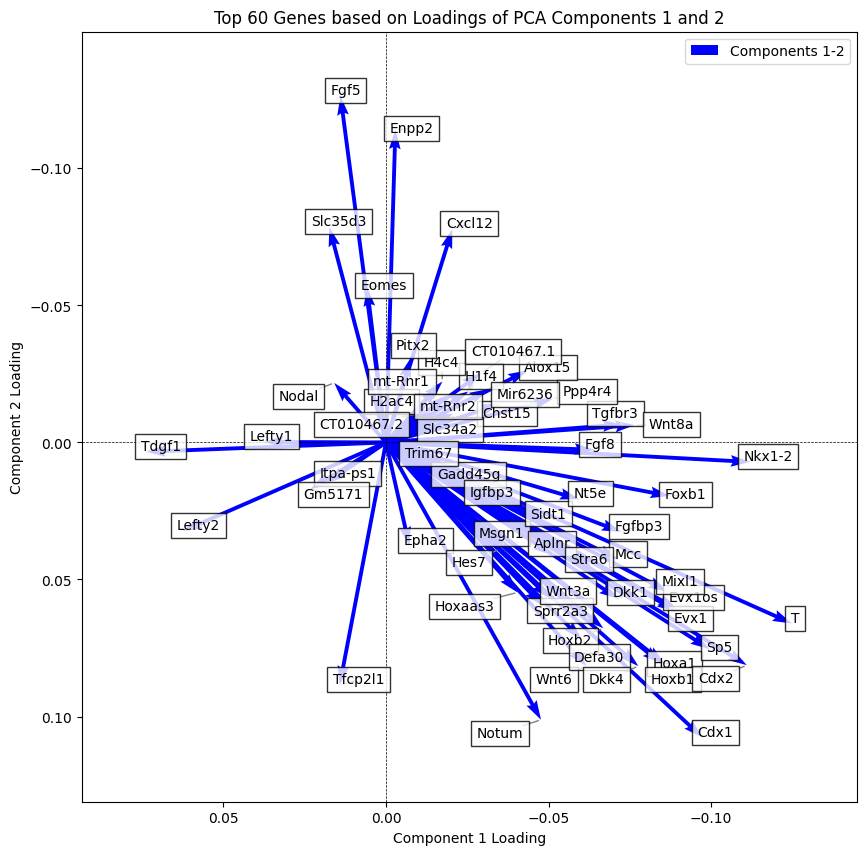

In [20]:
fig, ax = plt.subplots(figsize=(10,10))

plot_loadings_components(pca,0,1,df1_fs.columns.values,60,ax)

ax.invert_xaxis()
ax.invert_yaxis()

plt.savefig(f"results/bulk_analysis_pca_loadings.{save_format}",bbox_inches="tight",transparent=True)

# Marker Genes

In [21]:
retain = ['48h','72h_0.5μMc-DMSO','72h_3μMc-DMSO','72h_20μMc-DMSO','72h_0.5μMc-CHIR','72h_3μMc-CHIR','72h_20μMc-CHIR']

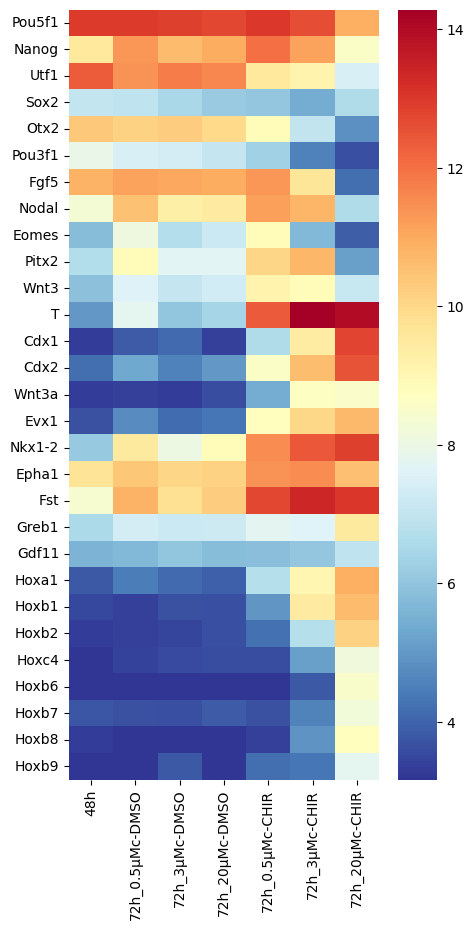

In [23]:
fig, ax = plt.subplots(1,1,figsize=(5,10))

d_ = df1.loc[:,marker_genes].groupby([i.split("_")[1]+"_"+i.split("_")[0] for i in df_gastruloid_metadata["ID"]]).mean()
d_.index = ['0h','48h','60h_20μMc-CHIR','60h_3μMc-CHIR','72h_0.5μMc-CHIR','72h_20μMc-CHIR','72h_3μMc-CHIR','72h_0.5μMc-DMSO','72h_20μMc-DMSO','72h_3μMc-DMSO']

sns.heatmap(
    d_.loc[retain,:].transpose(),
    cmap="RdYlBu_r"
)

plt.savefig(f"results/bulk_analysis_marker_genes_heatmap.{save_format}",bbox_inches="tight",transparent=True)